In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 3.1 Simulation of the data

In [2]:
np.random.seed(6996)
# error term
epsilon_vec = np.random.normal(0,1,500).reshape(500,1)
# X_matrix or regressors or predictiors
X_mat = np.random.normal(0,2,size = (500,500))
# Slope
slope_vec = np.random.uniform(1,5,500)
# Simulate Ys
Y_mat = 1 + np.cumsum(X_mat * slope_vec,axis=1)[:,1:] + epsilon_vec
# each col of Y_mat representing one simulation vector: starting with 2 regressors, end with 500
print(Y_mat.shape)

(500, 499)


# 3.2 Fitting linear models

## 1) Fit linear model with the first 10 predictors.

#### I noticed a problem that the different seperation of train and test dataset can affect results a lot...

#### Sometimes the M.S.E. of out pf sample test is evenly smaller than result of train data.

In [39]:
#Generate random dataset for train and test, the ratio is 7:3.
a = list(range(500))
np.random.shuffle(a)

train_location = a[:350]
test_location = a[-150:]


X_train = X_mat[train_location,0:10]
X_test = X_mat[test_location,0:10]

Y_train = Y_mat[train_location,8]
Y_test = Y_mat[test_location,8]

In [40]:
v10 = linear_model.LinearRegression()

v10.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
mean_squared_error(Y_train, v10.predict(X_train))

0.88324984848015087

In [42]:
mean_squared_error(Y_test, v10.predict(X_test))

1.0813571569200369

## 2) Fit linear model with 490 predictors.

In [43]:
v490 = linear_model.LinearRegression()

v490.fit(X_mat[train_location,0:490], Y_mat[train_location,488])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
mean_squared_error(Y_mat[train_location,488], v490.predict(X_mat[train_location,0:490]))

1.8953862672041738e-25

In [45]:
mean_squared_error(Y_mat[test_location,488], v490.predict(X_mat[test_location,0:490]))

5513.124209156329

We can see that in the first regression, the difference between M.S.E. of train data and test data are small.

However, there is a huge difference between train and test results in the second regression, so, there is a overfitting problem.

# 3.3 Ridge regression

In [46]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

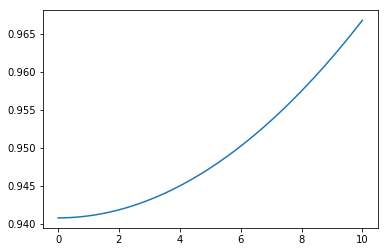

In [47]:
alphas_to_test = np.linspace(1e-10, 10)

rcv = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv.fit(X_train, Y_train)

plt.figure()
plt.plot(alphas_to_test, rcv.cv_values_.mean(axis=0))
plt.show()

We can see the mse decreases when the parameter decreases, maybe we  should just focus on small values to find the best parameter.

So change the linear space to np.linspace(1e-10, 0.1) and run again.

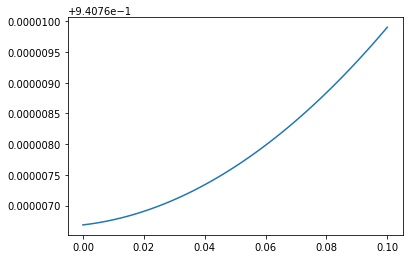

In [48]:
alphas_to_test = np.linspace(1e-10, 0.1)

rcv = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv.fit(X_train, Y_train)

plt.figure()
plt.plot(alphas_to_test, rcv.cv_values_.mean(axis=0))
plt.show()

To find a more precise lambda, decrease the range to np.linspace(0.01, 0.1)

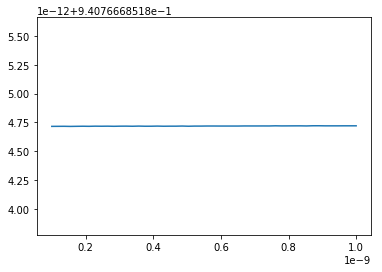

In [50]:
alphas_to_test = np.linspace(1e-10,1e-9)

rcv = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv.fit(X_train, Y_train)

plt.figure()
plt.plot(alphas_to_test, rcv.cv_values_.mean(axis=0))
plt.show()

In [51]:
# locate the parameter of the best result
smallest_idx = rcv.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

1.5510204081632656e-10

In [52]:
ridgereg = Ridge(alpha=alphas_to_test[smallest_idx],normalize=True)
ridgereg.fit(X_train, Y_train)

Ridge(alpha=1.5510204081632656e-10, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [53]:
ridgereg.coef_

array([ 1.37958151,  1.7259792 ,  4.31057943,  4.02756331,  2.31245634,
        3.27425973,  3.31664746,  4.53810972,  1.54898311,  4.80519631])

In [54]:
mean_squared_error(Y_train, ridgereg.predict(X_train))

0.8832498484801512

In [55]:
mean_squared_error(Y_test, ridgereg.predict(X_test))

1.0813571569519016

We can see the result is basically the same with the linear regression because the best lambda is too small to punish coeffients and ridge regression becomes basically the same with OLS linear regression.

And maybe because there is not a overfitting problem and all the variables are not collinear, so, the best lambda is very small. It feels like the coeffients caculated by OLS is already good enough, adding L2 penalty just would not improve out of sample predict.

# 3.4 Lasso regression

## 1) Fit lasso regression to the first 10 predictors.

In [56]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [57]:
lcv = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9,1e-10])
lcv.fit(X_train, Y_train)

LassoCV(alphas=[1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [58]:
lcv.alpha_

0.0001

In [59]:
lcv.mse_path_

array([[ 5.26150907,  3.19568849,  4.34664653],
       [ 1.20447537,  0.98358998,  0.96008509],
       [ 1.10051896,  1.01564768,  0.93128957],
       [ 1.09312995,  1.02138631,  0.93151059],
       [ 1.09239208,  1.02199014,  0.93156745],
       [ 1.09231854,  1.02206922,  0.93157427],
       [ 1.09231119,  1.02207736,  0.93157502],
       [ 1.09231045,  1.02207818,  0.9315751 ],
       [ 1.09231038,  1.02207826,  0.93157511],
       [ 1.09231037,  1.02207827,  0.93157511],
       [ 1.09231037,  1.02207827,  0.93157511]])

We can see the best alpha is 1e-10, but M.S.E.s are basically unchanged when alpha is smaller than 0.001. So, maybe we should just find a relatively big alpha to shrink features.

In [60]:
lcv = LassoCV(alphas = np.linspace(0.1, 1e-4))
lcv.fit(X_train, Y_train)

LassoCV(alphas=array([ 0.1    ,  0.09796,  0.09592,  0.09388,  0.09184,  0.08981,
        0.08777,  0.08573,  0.08369,  0.08165,  0.07961,  0.07757,
        0.07553,  0.0735 ,  0.07146,  0.06942,  0.06738,  0.06534,
        0.0633 ,  0.06126,  0.05922,  0.05719,  0.05515,  0.05311,
        0.05107,  0.04903...1641,
        0.01437,  0.01233,  0.01029,  0.00826,  0.00622,  0.00418,
        0.00214,  0.0001 ]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [61]:
lcv.alpha_

0.0001

In [62]:
lcv.coef_

array([ 1.37954933,  1.72593822,  4.31055256,  4.02754184,  2.31242544,
        3.27423868,  3.31661166,  4.5380838 ,  1.54895083,  4.80516702])

In [63]:
mean_squared_error(Y_train, lcv.predict(X_train))

0.8832498785278452

In [64]:
mean_squared_error(Y_test, lcv.predict(X_test))

1.0813382565826588

We can see lasso regression actually improved the M.S.E. of test dataset a little bit. The M.S.E. of OLS linear regression and ridge regression are both 1.0813571569200369. So, there is a tiny improvement if it really counts.....

Again, because lambda is small, so, it's basically the same with OLS linear regression.

## 2) Fit the model to the entire data

The procedure is basically the same with above.

In [65]:
lcv2 = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9,1e-10])
lcv2.fit( X_mat[:,0:10], Y_mat[:,8])

LassoCV(alphas=[1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [66]:
lcv2.mse_path_

array([[ 4.47143962,  3.51910148,  4.16224045],
       [ 1.16711008,  1.06062493,  0.82590162],
       [ 1.12567937,  1.04786263,  0.7814909 ],
       [ 1.12442737,  1.04892056,  0.77994233],
       [ 1.12433035,  1.04905347,  0.77981693],
       [ 1.12432227,  1.049061  ,  0.77980584],
       [ 1.12432146,  1.04906174,  0.77980476],
       [ 1.12432138,  1.04906182,  0.77980465],
       [ 1.12432137,  1.04906182,  0.77980464],
       [ 1.12432137,  1.04906182,  0.77980464],
       [ 1.12432137,  1.04906182,  0.77980464]])

In [67]:
lcv2 = LassoCV(alphas = np.linspace(0.1, 1e-4))
lcv2.fit( X_mat[:,0:10], Y_mat[:,8])

LassoCV(alphas=array([ 0.1    ,  0.09796,  0.09592,  0.09388,  0.09184,  0.08981,
        0.08777,  0.08573,  0.08369,  0.08165,  0.07961,  0.07757,
        0.07553,  0.0735 ,  0.07146,  0.06942,  0.06738,  0.06534,
        0.0633 ,  0.06126,  0.05922,  0.05719,  0.05515,  0.05311,
        0.05107,  0.04903...1641,
        0.01437,  0.01233,  0.01029,  0.00826,  0.00622,  0.00418,
        0.00214,  0.0001 ]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [68]:
lcv2.alpha_

0.0001

In [69]:
lcv2.coef_

array([ 1.36740697,  1.70757863,  4.31399574,  4.02529645,  2.30292234,
        3.27925285,  3.31989651,  4.55101079,  1.54533001,  4.80463406])

In [70]:
v10.coef_

array([ 1.37958151,  1.7259792 ,  4.31057943,  4.02756331,  2.31245634,
        3.27425973,  3.31664746,  4.53810972,  1.54898311,  4.80519631])

Again, we can see they are almost the same because lambda is so small.

# 3.5 Large number of significant predictors

## 1) result when lambda = 0

In [71]:
lassoreg_0 = Lasso(alpha=0,normalize=True, max_iter=1e5)
lassoreg_0.fit(X_mat[:,0:490], Y_mat[:,488])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
D:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
lassoreg_0.coef_[lassoreg_0.coef_ < 1]

array([ 0.78724459,  0.93963005,  0.99678308,  0.93782429,  0.91466242,
        0.98409026,  0.74803667,  0.8721131 ,  0.97201186,  0.97813672,
        0.62368825,  0.89817638,  0.80644843,  0.94808417,  0.83710077,
        0.99503358])

I did not understand what the instruction said when lambda is 0, the coeffients would be pushed to zero.

When lambda is zero, isn't it the same with OLS linear regression?

## 2) Calculate mean squares prediction error for the best lambda

In [73]:
lassoreg = LassoCV(alphas = [100,10,1, 0.1, 0.01,0.001, 1e-4, 1e-5], max_iter=1e6)
lassoreg.fit(X_mat[:,0:490], Y_mat[:,488])

LassoCV(alphas=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], copy_X=True,
    cv=None, eps=0.001, fit_intercept=True, max_iter=1000000.0,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [74]:
lassoreg.mse_path_

array([[ 20474.16037023,  21261.85959038,  21024.64327798],
       [ 14858.73085666,  14173.90778971,  14054.38249957],
       [ 11584.09614826,  10052.90525758,  11604.05124372],
       [ 11128.43301186,  10841.10367145,  11225.88307323],
       [ 11077.08961202,  10863.62634836,  11211.84568442],
       [ 11071.90372961,  10867.61975617,  11206.68239675],
       [ 11071.55255006,  10867.90916944,  11206.17625983],
       [ 11071.5346556 ,  10868.02795224,  11205.94768665]])

We can see M.S.E.s would not change a lot when lambda is less than 1. So we can narrow the range to find the best lambda.

In [75]:
lassoreg = LassoCV(alphas = np.linspace(1, 0.01), max_iter=1e6)
lassoreg.fit(X_mat[:,0:490], Y_mat[:,488])

LassoCV(alphas=array([ 1.     ,  0.9798 ,  0.95959,  0.93939,  0.91918,  0.89898,
        0.87878,  0.85857,  0.83837,  0.81816,  0.79796,  0.77776,
        0.75755,  0.73735,  0.71714,  0.69694,  0.67673,  0.65653,
        0.63633,  0.61612,  0.59592,  0.57571,  0.55551,  0.53531,
        0.5151 ,  0.4949 ...7163,
        0.15143,  0.13122,  0.11102,  0.09082,  0.07061,  0.05041,
        0.0302 ,  0.01   ]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000000.0, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [76]:
lassoreg.alpha_

0.39387755102040822

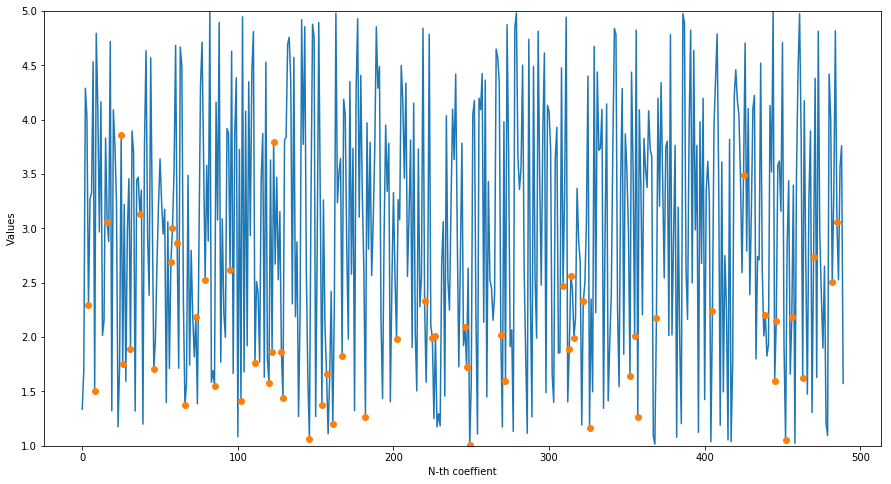

In [77]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8
plt.figure()
x_axis = np.arange(490)
plt.ylim(1.0,5.0)

plt.plot(x_axis,slope_vec[:490])

plt.plot(x_axis[lassoreg.coef_ == 0.0],slope_vec[:490][lassoreg.coef_ == 0.0],'o')

plt.xlabel('N-th coeffient')
plt.ylabel('Values')

plt.show()

As the instruction said, Lasso removed predictors seemingly randomly regardless of the value of slope. 

It also seems that most removed slopes are under the lower part, but yes, still quite random.....